In [1]:
%pylab

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
%matplotlib inline

In [3]:
import GPy, scipy

## Bayesian Linear Regression 

In [4]:
def phi_gen(p):
    return lambda x: np.array([x**i for i in range(p+1)]).T

phi3 = phi_gen(3)

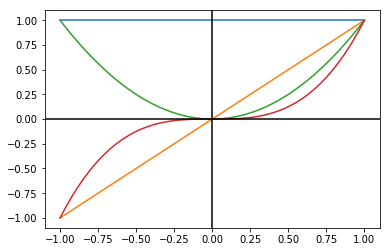

In [50]:
x = np.linspace(-1,1)

plt.plot(x, phi3(x));

plt.axhline(0, color='black')
plt.axvline(0, color='black')

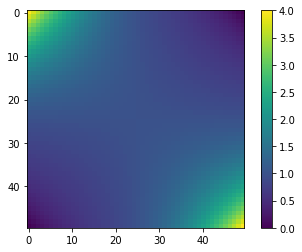

In [51]:
beta_cov = np.eye(4)
# beta_cov[]

f_cov = np.dot(phi3(x), np.dot(beta_cov, phi3(x).T))

plt.imshow(f_cov)
plt.colorbar()

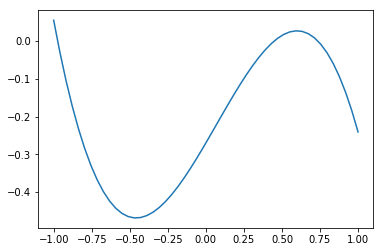

In [52]:
f = scipy.stats.multivariate_normal.rvs(np.zeros(50), f_cov)

plt.plot(x,f)

In [59]:
def fdist(x, phi, beta_cov, sigma = 0.0):
    f_cov = np.dot(phi(x), np.dot(beta_cov, phi(x).T)) + np.eye(x.shape[0])*sigma
    
    jit = 1e-6
    excp = None
    #return scipy.stats.multivariate_normal(np.zeros(x.shape[0]), f_cov+jit*np.eye(x.shape[0]))
    while jit<1e1:
        try:
            #return scipy.stats.multivariate_normal(np.zeros(x.shape[0]), f_cov)
            return scipy.stats.multivariate_normal(np.zeros(x.shape[0]), f_cov+jit*np.eye(x.shape[0]))
        except np.linalg.LinAlgError as e:
            jit = jit*10
            excp = e
    
    raise excp

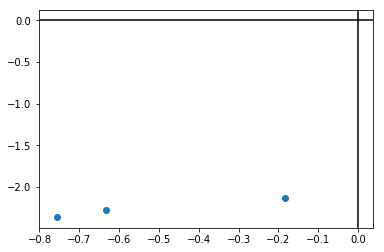

In [60]:
p = 10
xsamp = np.random.choice(x, size=3, replace=False)
fsamp = fdist(xsamp, phi_gen(p), np.eye(p+1)).rvs()

plt.scatter(xsamp, fsamp)
plt.axhline(0, color='black')
plt.axvline(0, color='black')

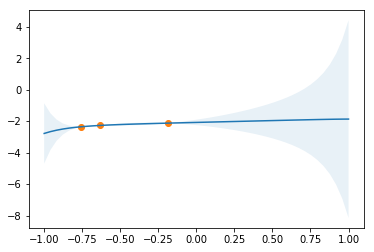

In [61]:
kzx = np.dot(phi_gen(p)(x), np.dot(np.eye(p+1), phi_gen(p)(xsamp).T))
kzz = np.dot(phi_gen(p)(x), np.dot(np.eye(p+1), phi_gen(p)(x).T))
kxx = np.dot(phi_gen(p)(xsamp), np.dot(np.eye(p+1), phi_gen(p)(xsamp).T))

mu_pred = np.dot(kzx, np.dot(np.linalg.inv(kxx), fsamp))
cov_pred = kzz - np.dot(kzx, np.dot(np.linalg.inv(kxx), kzx.T))
cov_pred[cov_pred<0] = 0
std_pred = np.sqrt(np.diag(cov_pred))

# plt.subplot(121)
plt.plot(x, mu_pred)
plt.fill_between(x, mu_pred-2*std_pred, mu_pred+2*std_pred, alpha=.1)
plt.scatter(xsamp, fsamp)

Add observation noise

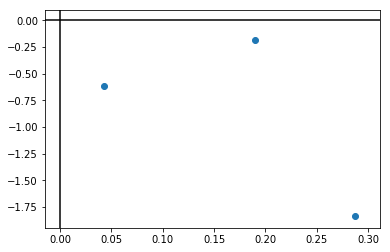

In [98]:
x = np.linspace(-.3,.3)

sigma = 5e-1
p = 10
xsamp = np.random.choice(x, size=3, replace=False)
fsamp = fdist(xsamp, phi_gen(p), np.eye(p+1), sigma=sigma).rvs()

plt.scatter(xsamp, fsamp)
plt.axhline(0, color='black')
plt.axvline(0, color='black')

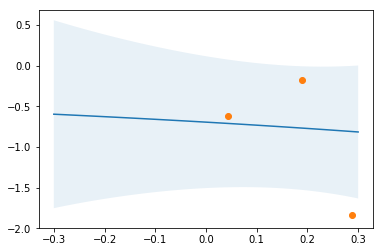

In [99]:
kzx = np.dot(phi_gen(p)(x), np.dot(np.eye(p+1), phi_gen(p)(xsamp).T))
kzz = np.dot(phi_gen(p)(x), np.dot(np.eye(p+1), phi_gen(p)(x).T))
kxx = np.dot(phi_gen(p)(xsamp), np.dot(np.eye(p+1), phi_gen(p)(xsamp).T)) + sigma*np.eye(xsamp.shape[0])

mu_pred = np.dot(kzx, np.dot(np.linalg.inv(kxx), fsamp))
cov_pred = kzz - np.dot(kzx, np.dot(np.linalg.inv(kxx), kzx.T))
cov_pred[cov_pred<0] = 0
std_pred = np.sqrt(np.diag(cov_pred))

# plt.subplot(121)
plt.plot(x, mu_pred)
plt.fill_between(x, mu_pred-2*std_pred, mu_pred+2*std_pred, alpha=.1)
plt.scatter(xsamp, fsamp)

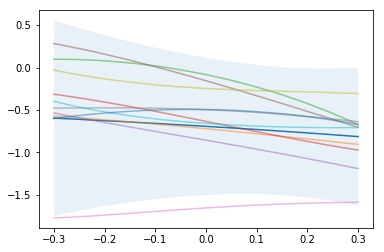

In [100]:
plt.plot(x, mu_pred)
plt.fill_between(x, mu_pred-2*std_pred, mu_pred+2*std_pred, alpha=.1)
plt.plot(x, scipy.stats.multivariate_normal.rvs(mu_pred, cov_pred, size=10).T,alpha=.5);

## GP basics

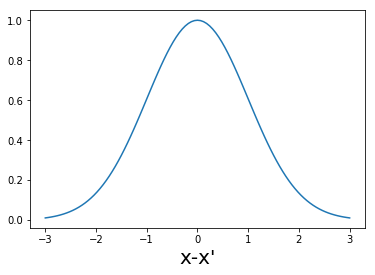

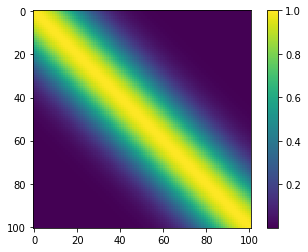

In [26]:
x = np.linspace(-3,3, 101)[:,None]
kern = GPy.kern.RBF(1)

plt.plot(x[x.shape[0]/2,0] - x, kern.K(x)[x.shape[0]/2,:])
plt.xlabel("x-x'", fontsize=20)

plt.figure()
plt.imshow(kern.K(x))
plt.colorbar()

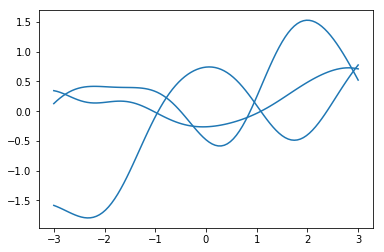

In [58]:
s1 = scipy.stats.multivariate_normal.rvs(np.zeros(x.shape[0]), kern.K(x), size=3).T

plt.plot(x, s1, c='C0');

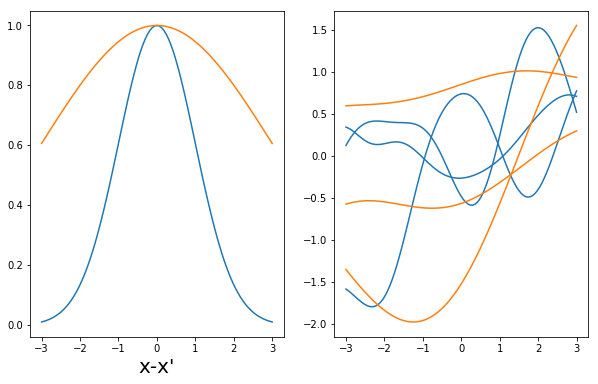

In [64]:
# kern2 = GPy.kern.RBF(1, variance=1e0, lengthscale=1e0)
kern2 = GPy.kern.RBF(1, variance=1e0, lengthscale=3e0)
# kern2 = GPy.kern.RBF(1, variance=1e0, lengthscale=5e-1)
# kern2 = GPy.kern.RBF(1, variance=1e-1, lengthscale=1e0)
# kern2 = GPy.kern.RBF(1, variance=1e1, lengthscale=1e0)

s2 = scipy.stats.multivariate_normal.rvs(np.zeros(x.shape[0]), kern2.K(x), size=3).T

plt.figure(figsize=(10,6))

plt.subplot(121)
plt.plot(x[x.shape[0]/2,0] - x, kern.K(x)[x.shape[0]/2,:])
plt.plot(x[x.shape[0]/2,0] - x, kern2.K(x)[x.shape[0]/2,:])
plt.xlabel("x-x'", fontsize=20)

plt.subplot(122)
plt.plot(x, s1, c='C0');
plt.plot(x, s2, c='C1');